# <center> <span style=""><font size="+3"> k-Nearest Neighbors and k-Means Clustering Algorithm Implementation from scratch </font></span> </center> #
<br/>
<center> <span style="color:red; font-size : 18px">Auteur </span> <span style="font-size : 18px"> : Bounhar Abdelaziz </span> </center>

In [47]:
import numpy as np
import pandas as pd
from sys import float_info
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import mean_squared_error

In [48]:
%matplotlib inline

# I. Toy data set

In [49]:
#size per label 
N = 100

# Gaussian mean for distribution label 0
mu_label_0 = np.array([-1,0])

# Gaussian mean for distribution label 1
mu_label_1 = np.array([1,0])

# Gaussian mean for distribution label 2
mu_label_2 = np.array([0,1])

# standar deviation for Gaussian Distribution
sigma_ = 0.10 
matrix_cov =sigma_* np.array([[1, 0],[0, 1]])



In [50]:
def generate_data(N, mu_label_0, mu_label_1, mu_label_2, matrix_cov):
    """This function generate the data that we will use"""
    
    #Data Generate with Gaussain Distribution
    X1 = np.random.multivariate_normal(mu_label_0, matrix_cov, N//1)
    X2 = np.random.multivariate_normal(mu_label_1, matrix_cov, N//1)
    X3 = np.random.multivariate_normal(mu_label_2, matrix_cov, N//1)
    
    X = np.concatenate((X1,X2,X3),axis=0)

    # Label Generate
    Y1 = np.zeros(N//1, dtype=int)
    Y2 = np.ones(N//1, dtype=int)
    Y3 = 2*np.ones(N//1)
    
    Y = np.array(np.append(Y1,Y2))
    Y =  np.array(np.append(Y,Y3))
    
    return X, Y

#---------------------------------------------------------------------------------------------------------------#
def plot_Data(X, Y):
    """This function plot the Gaussian Distribution"""
    plt.figure(figsize=(20,10))
    plt.scatter(X[:,0], X[:,1], c=Y)
    plt.show()
#---------------------------------------------------------------------------------------------------------------#
def plot_generated_data_set(X_train, X_test, Y_train, Y_test):
    """This function plot the generated data set"""

    plt.figure(figsize=(30,20))
    plt.scatter(X_train[:,0], X_train[:,1], s=250, c=Y_train, alpha=1, edgecolors='black', label='Training Data Set')
    plt.scatter(X_test[:,0], X_test[:,1], s=300, c=Y_test, alpha=0.5, label='Testing Data Set')
    plt.title("Generated data set")
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.show()
#---------------------------------------------------------------------------------------------------------------#
def standard_deviation(E):
    """This function return the standart deviation"""
    E = np.array(E)
    
    e = np.sum(E)/E.shape[0]
    return np.sqrt(np.sum((E-e)*(E-e)) / E.shape[0]) 
#---------------------------------------------------------------------------------------------------------------#
def mixte_data(X,Y):
    """This function return the dataset and label mixted"""
    X_mixte = list()
    Y_mixte = list()
    indice = np.arange(start=0,stop=X.shape[0])
    np.random.shuffle(indice)
    
    for i in range(indice.shape[0]):
        X_mixte.append(X[indice[i]])
        Y_mixte.append(Y[indice[i]])
    
    return np.array(X_mixte), np.array(Y_mixte)
#---------------------------------------------------------------------------------------------------------------#
def split_data(X,Y,percentage_training):
    """We use this function to divide the data into %percentage_training of training data and 
    (1-percentage_training)% of testing data"""
    
    XX, YY = mixte_data(X,Y)
    kk = round(percentage_training*XX.shape[0])
    
    X_train = list()
    Y_train = list()
        
    X_test  = list()
    Y_test  = list()
    
    
    for k in range(kk):
        X_train.append(XX[k])
        Y_train.append(YY[k])
        
    for j in range(k,XX.shape[0]):
        X_test.append(XX[j])
        Y_test.append(YY[j])
    
    return np.array(X_train), np.array(X_test), np.array(Y_train), np.array(Y_test)
#---------------------------------------------------------------------------------------------------------------#
def plot_decision_region(X_train, Y_train, X_test, Y_test, Y_pred):
    """function used to plot decision regions"""
    
    bad_predict = list()
    for i in range(len(Y_pred)):
        if(Y_pred[i]!=Y_test[i]):
            bad_predict.append(X_test[i])

    bad_predict = np.array(bad_predict)
    plt.figure(figsize=(30,20))

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])

    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    XXX = np.c_[xx.ravel(), yy.ravel()]
    # prediction
    Z = list()

    for i in XXX:
        Z.append(int(K_NN_predict(X_train, Y_train, i, 1)))

    Z = np.array(Z)
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha = 0.2, cmap = ListedColormap(('#f0027f', '#AAAAFF', '#FFFF00')))

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.scatter(X_train[:,0], X_train[:,1], s=500, c=Y_train, alpha=1, edgecolors='black', label='Training Data Set')
    plt.scatter(X_test[:,0], X_test[:,1], s=500, c=Y_test, alpha=0.5, label='Testing Data Set')
    plt.scatter(bad_predict[:,0], bad_predict[:,1], s=500, c="red", marker="x", cmap="BuGn", alpha=1, label='Error')

    plt.title("decision boundary")
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.show()
#----------------------------------------------------------------------------------------------------------------#

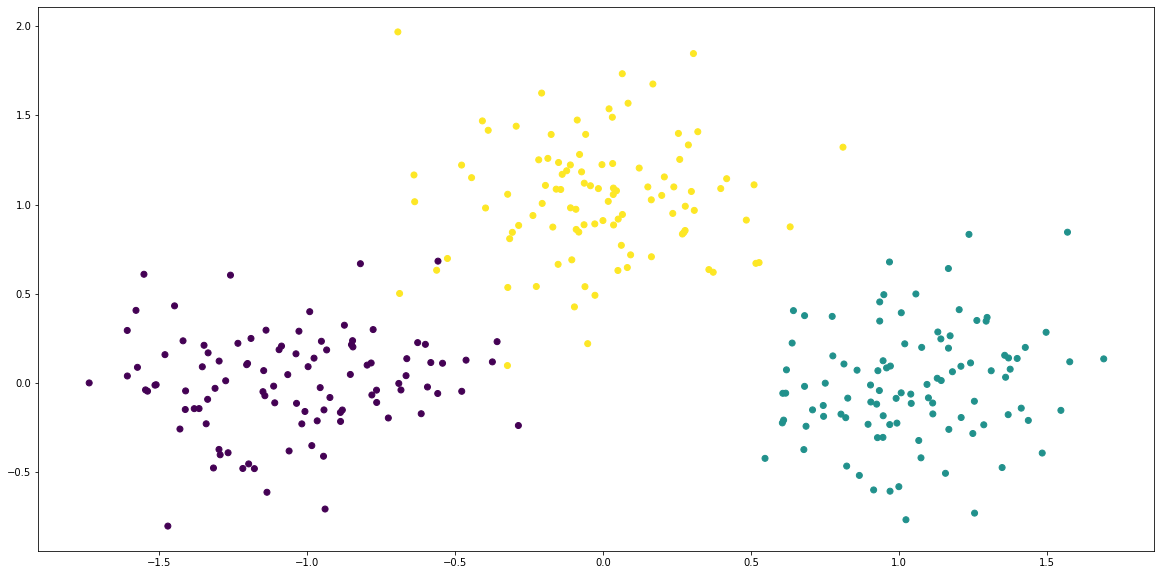

In [51]:
# Generation of the data
X,Y = generate_data(N, mu_label_0, mu_label_1, mu_label_2, matrix_cov)

# split data
X,Y = mixte_data(X,Y)

# split data
X_train, X_test, Y_train, Y_test = split_data(X, Y, 0.75)

plot_Data(X, Y)

## 1. k-NN algorithm for classification

### The K_NN algorithm

In [52]:
def K_NN_predict(X, Y, x_will_predict, k):
    """This function """
        
    neighbour = dict()
    
    for j in range(X.shape[0]):
        neighbour[j] = np.sqrt(np.sum((x_will_predict-X[j])*(x_will_predict-X[j])))
            
    #print(neighbour)
    k_nearest_neighbour = sorted(neighbour.items(), key=lambda t: t[1])[0:k]
    
    # list label
    label_list = list()
    
    for i in k_nearest_neighbour:
        label_list.append(Y[i[0]])
    
    get_the_label = dict()
    
    for i in label_list:
        if i in get_the_label:
            get_the_label[i]+=1
        else:
            get_the_label[i]=1
            
    get_the_label =  sorted(get_the_label.items(), key=lambda t: t[1])[0:k]
    
    return label_list[len(get_the_label)-1]
        

### Question 1

In [53]:
#size per label 
N = 100

# Gaussian mean for distribution label 0
mu_label_0 = np.array([-1,0])

# Gaussian mean for distribution label 1
mu_label_1 = np.array([1,0])

# Gaussian mean for distribution label 2
mu_label_2 = np.array([0,1])

# standar deviation for Gaussian Distribution
sigma_ = 0.10 
matrix_cov =sigma_* np.array([[1, 0],[0, 1]])

#different k_value
K_value = [1, 2, 5, 10]

# Generation of the data
X,Y = generate_data(N, mu_label_0, mu_label_1, mu_label_2, matrix_cov)

# split data
X_train, X_test, Y_train, Y_test = split_data(X, Y, 0.75)

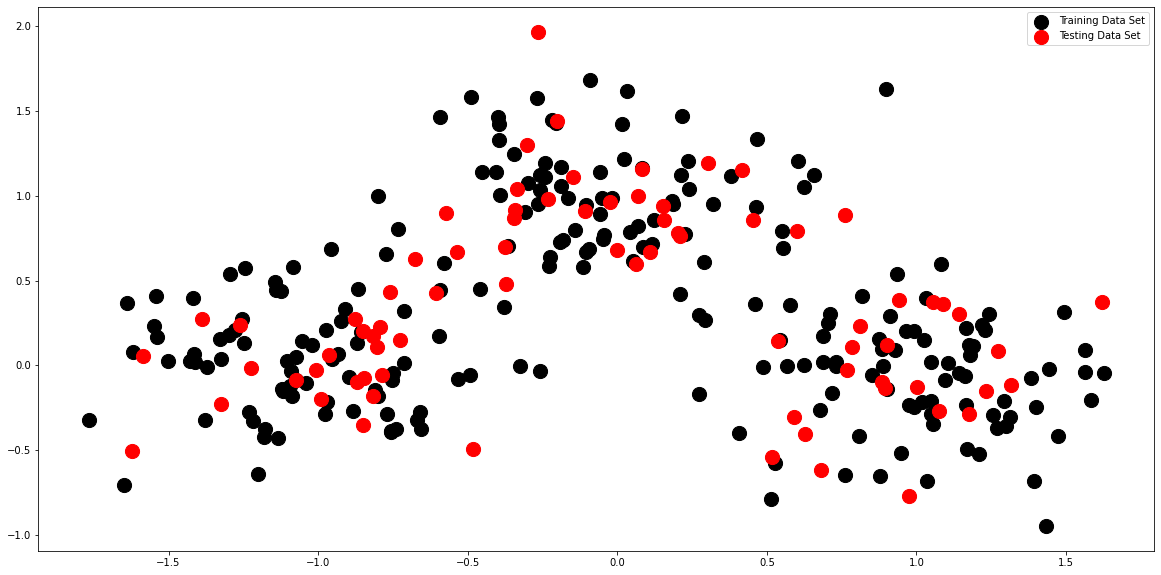

In [54]:
plt.figure(figsize=(20,10))
plt.scatter(X_train[:,0], X_train[:,1], c="black", s=200, label='Training Data Set')
plt.scatter(X_test[:,0], X_test[:,1], c="red", s=200, label='Testing Data Set')
plt.legend()
plt.show()

#### For k = 1

In [55]:
# prediction
Y_pred_k_1 = list()

for x_test in X_test:
    Y_pred_k_1.append(int(K_NN_predict(X_train, Y_train, x_test, 1)))
    
accuracy_1 = accuracy_score(np.array(Y_test),np.array(Y_pred_k_1) )

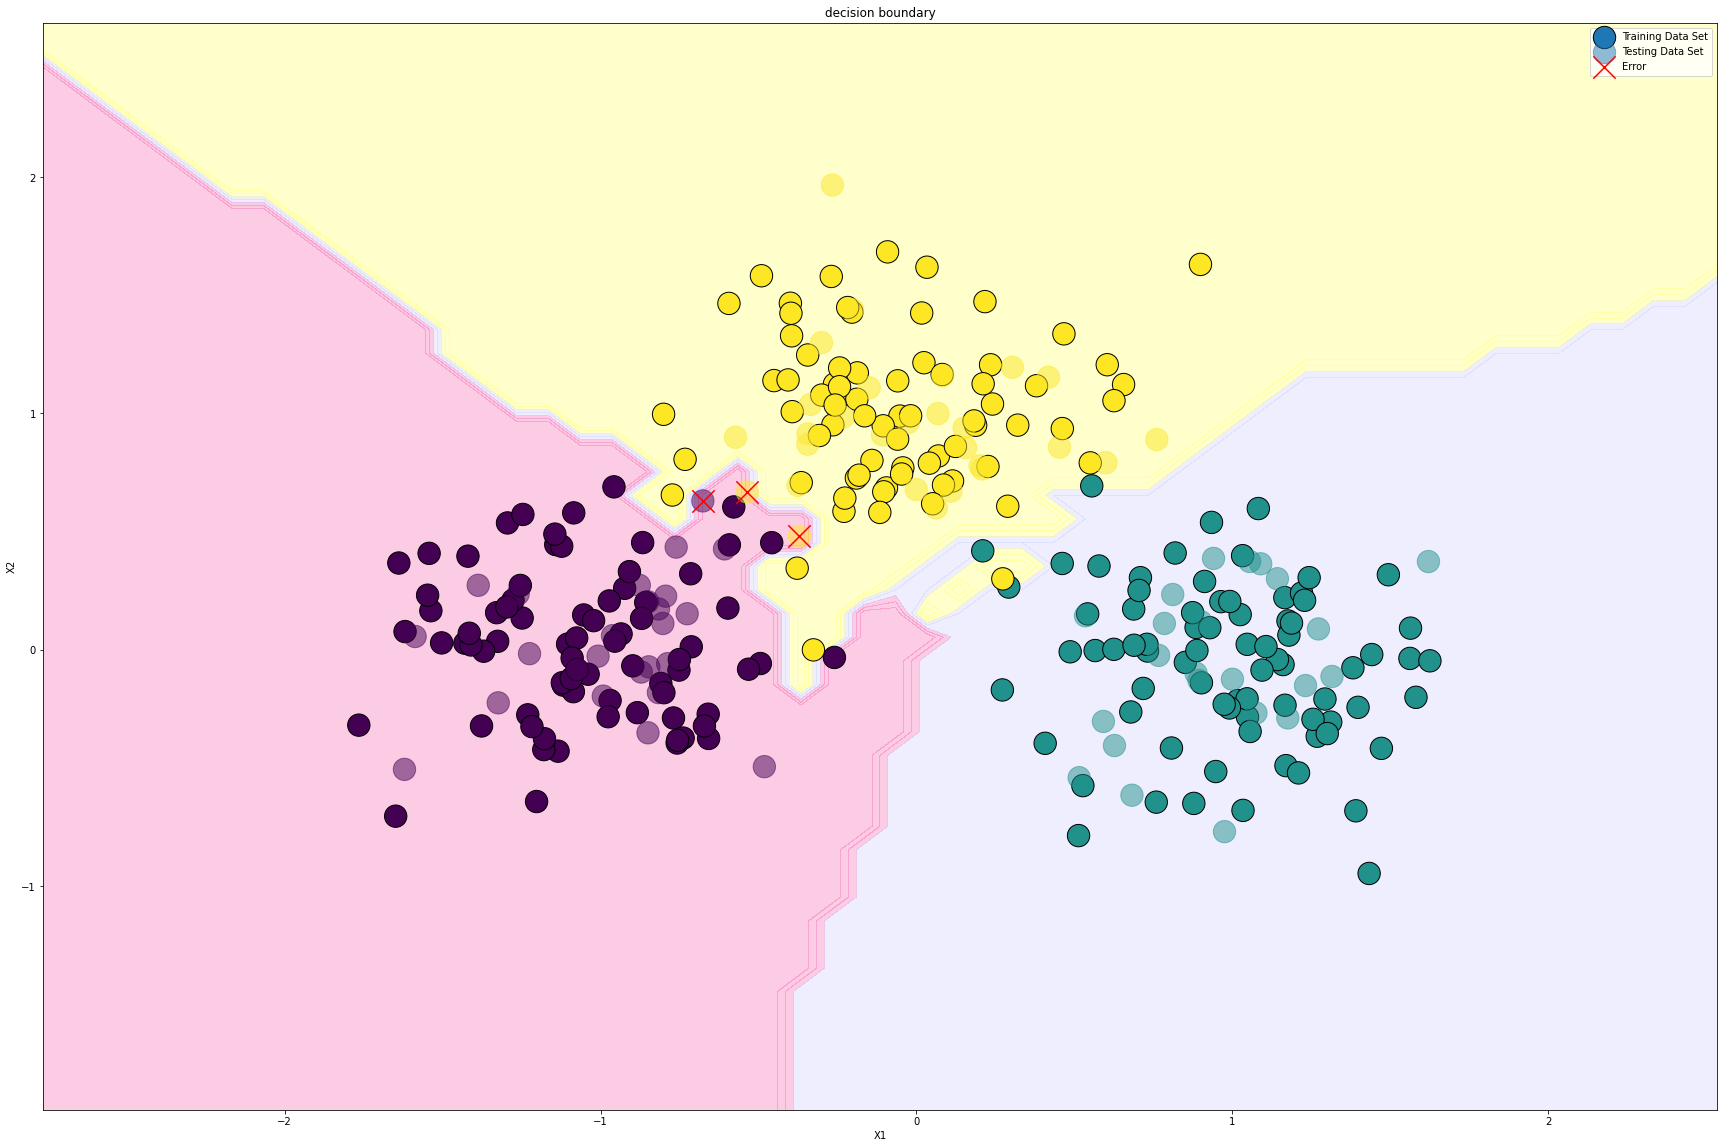

In [56]:
plot_decision_region(X_train, Y_train, X_test, Y_test, Y_pred_k_1)

#### For k = 2

In [57]:
# prediction
Y_pred_k_2 = list()

for x_test in X_test:
    Y_pred_k_2.append(int(K_NN_predict(X_train, Y_train, x_test, 2)))
    
accuracy_2 = accuracy_score(np.array(Y_test),np.array(Y_pred_k_2) )

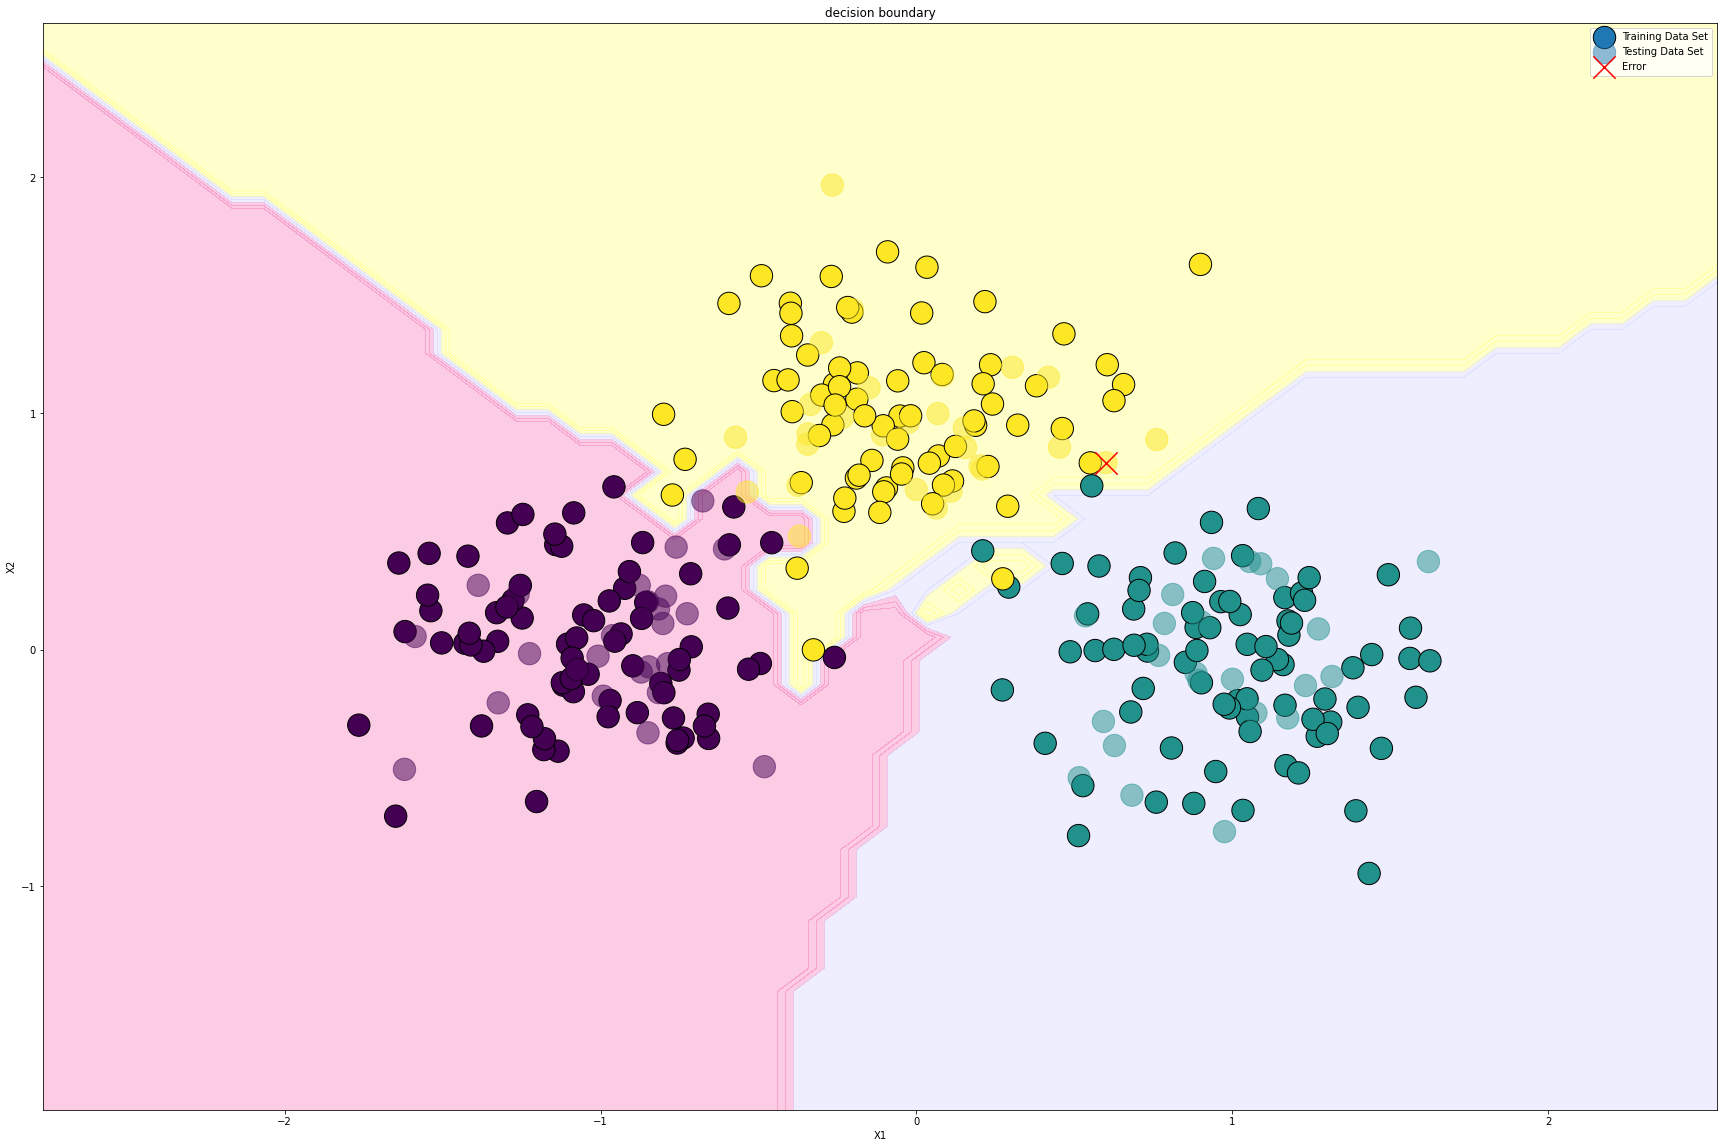

In [58]:
plot_decision_region(X_train, Y_train, X_test, Y_test, Y_pred_k_2)

#### For k = 5

In [59]:
# prediction
Y_pred_k_5 = list()

for x_test in X_test:
    Y_pred_k_5.append(int(K_NN_predict(X_train, Y_train, x_test, 5)))
    
accuracy_5 = accuracy_score(np.array(Y_test),np.array(Y_pred_k_5) )

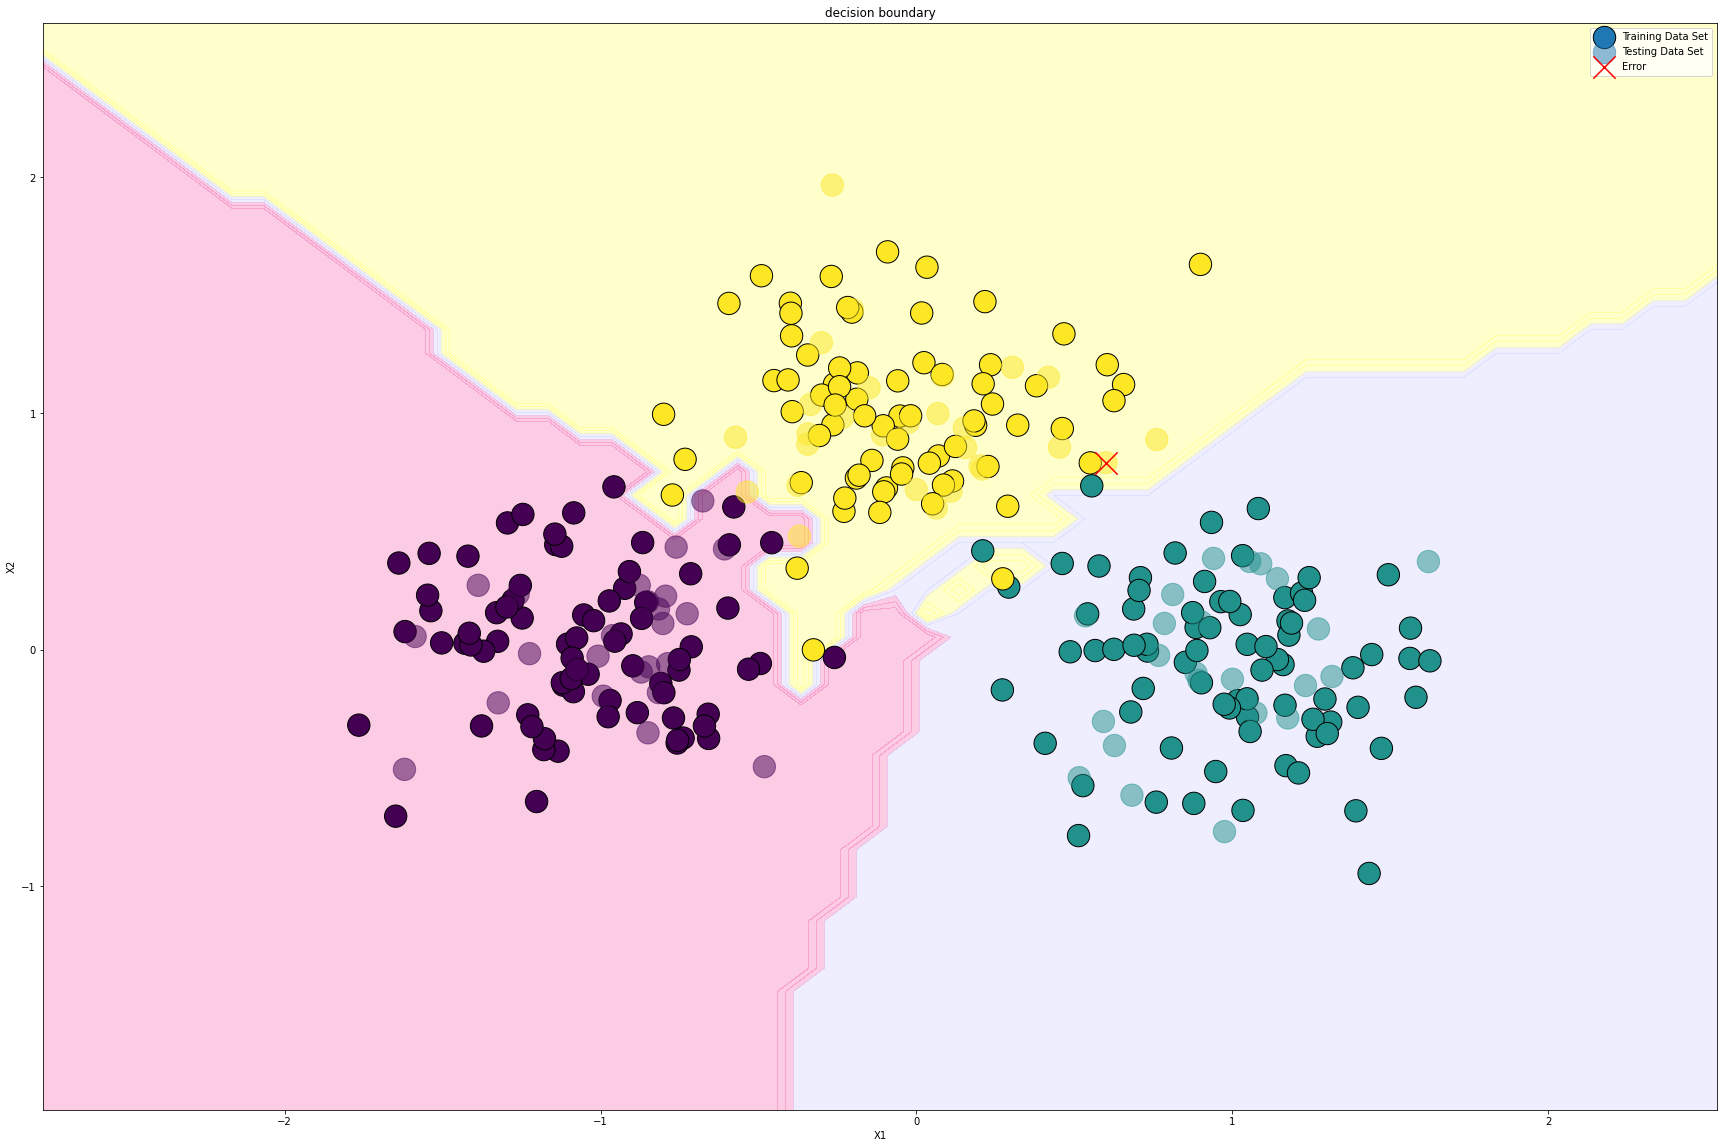

In [60]:
plot_decision_region(X_train, Y_train, X_test, Y_test, Y_pred_k_5)

### For k = 10

In [61]:
# prediction
Y_pred_k_10 = list()

for x_test in X_test:
    Y_pred_k_10.append(int(K_NN_predict(X_train, Y_train, x_test, 10)))
    
accuracy_10 = accuracy_score(np.array(Y_test),np.array(Y_pred_k_10) )

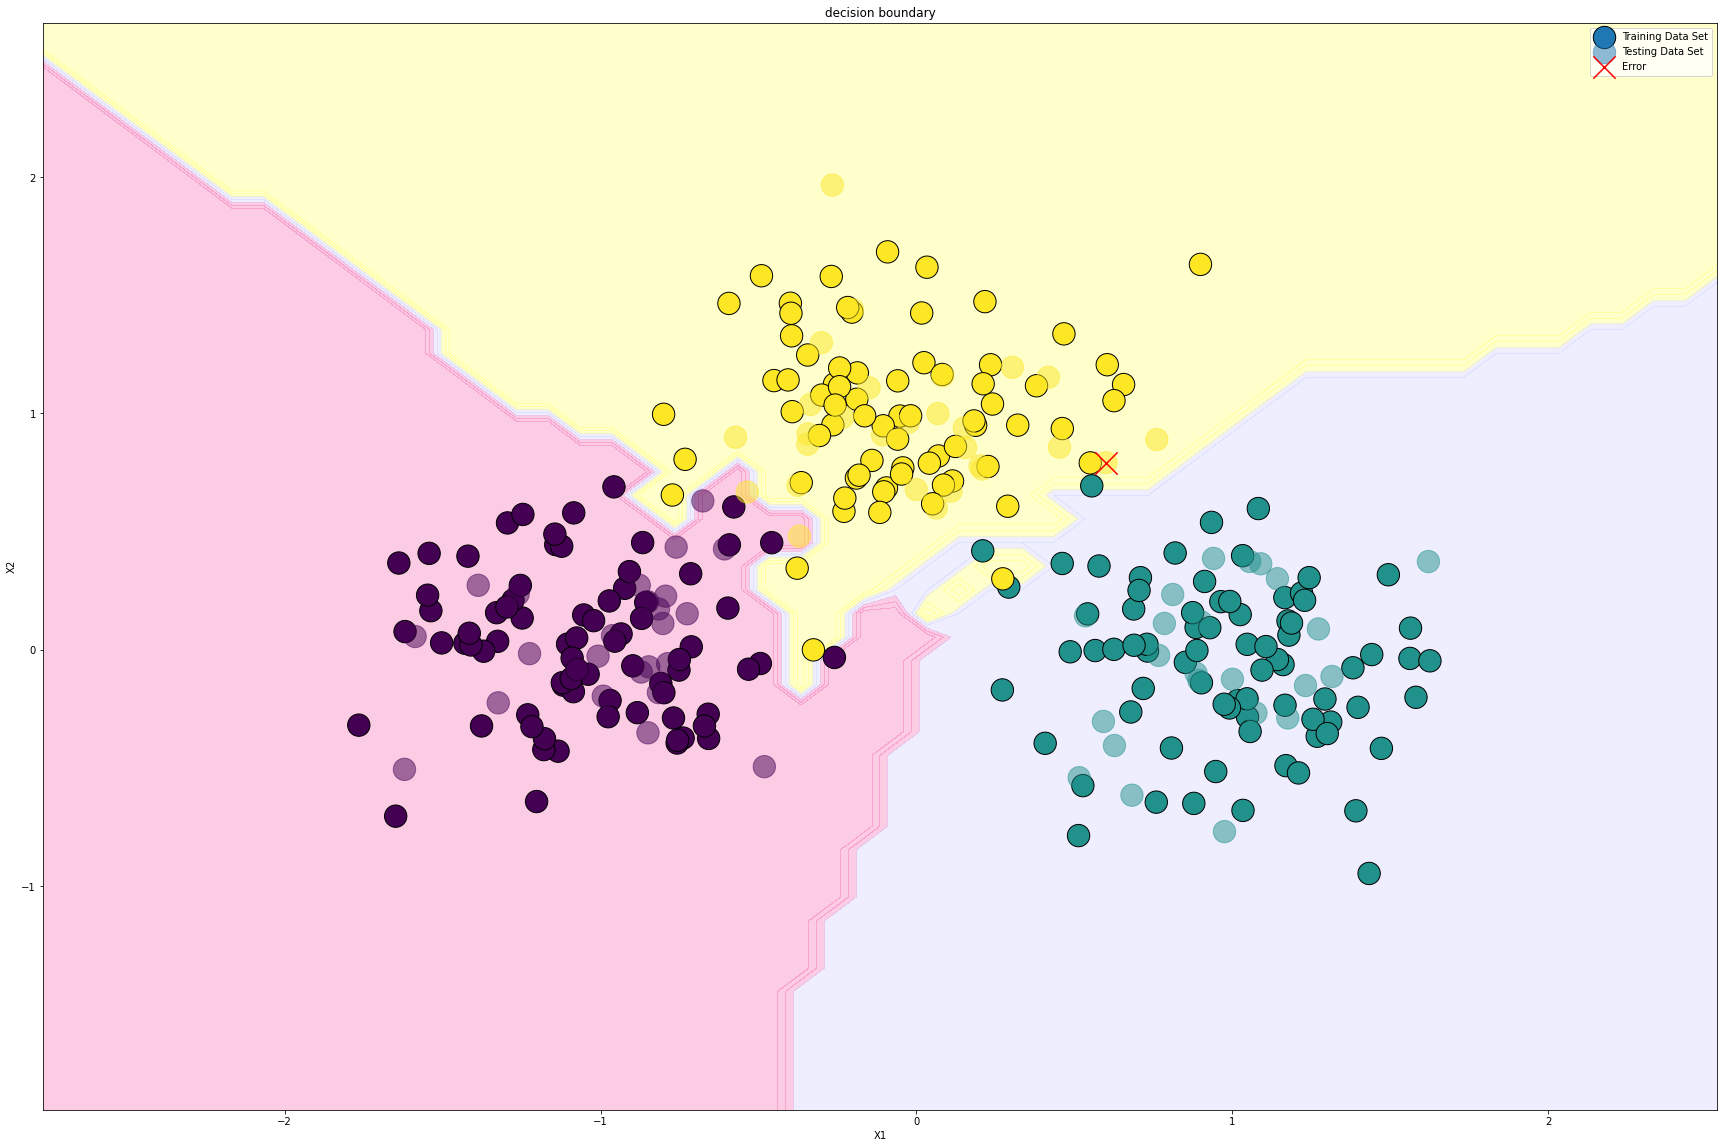

In [62]:
plot_decision_region(X_train, Y_train, X_test, Y_test, Y_pred_k_10)

#### Comment :

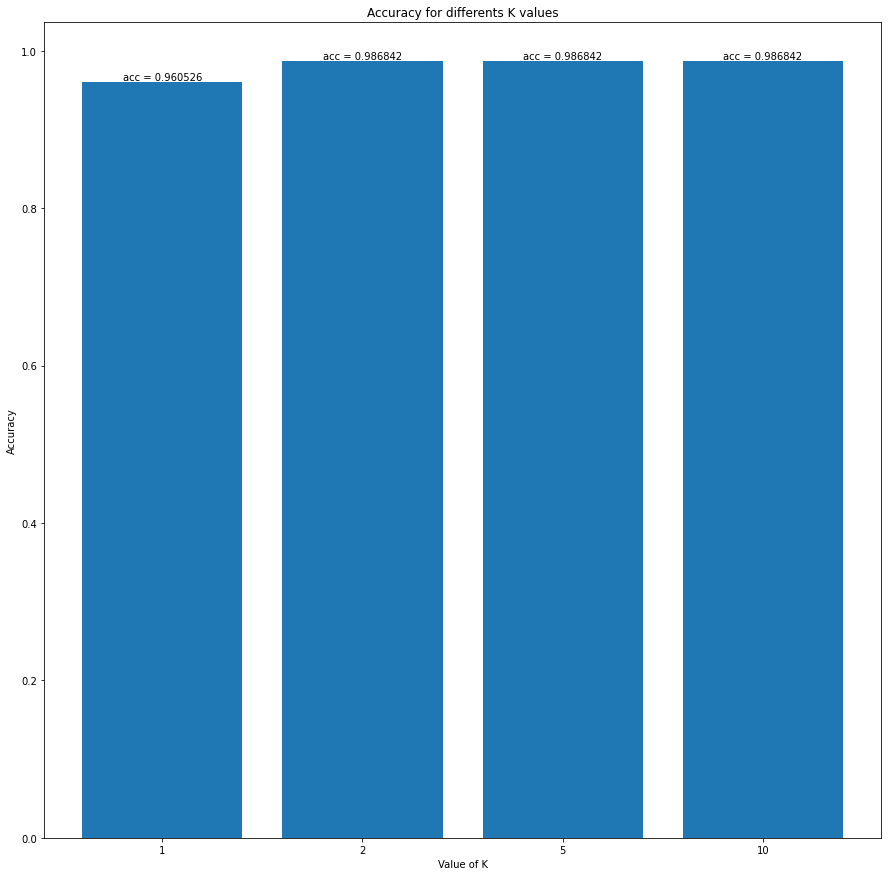

In [63]:
plt.figure(figsize=(15,15))

k_value = list()
for i in K_value:
    k_value.append(str(i))
    
accuracy = [accuracy_1, accuracy_2, accuracy_5, accuracy_10]
unit = accuracy
 
plot = plt.bar(k_value, accuracy)
 
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2., height,'acc = %f' % height, ha='center', va='bottom')

plt.title("Accuracy for differents K values")
plt.xlabel('Value of K')
plt.ylabel('Accuracy')
 
# show the graph
plt.show()

## Comments : 

We can see that there is an increase in error as k increases which is normal because, with one neighbor, we are almost sure (overfitting the data).

### Question 2

In [64]:
#size per label 
N = 100

# Gaussian mean for distribution label 0
mu_label_0 = np.array([-1,0])

# Gaussian mean for distribution label 1
mu_label_1 = np.array([1,0])

# Gaussian mean for distribution label 2
mu_label_2 = np.array([0,1])

# noise variance sigma_2
sigma_2 = [0.15, 0.20, 0.25]

# for sigma equal 0.10
sigma_0 = 0.10

# k parameter
k_parameter = 1

##### sigma = 0.10 and k=1

In [65]:
# average error of the model
average_error_sigma_0 = 0.0

# standar deviation of the model
standard_deviation_sigma_0 = 0.0

# standar deviation for Gaussian Distribution for sigma equal 0 
matrix_cov =sigma_0* np.array([[1, 0],[0, 1]])
    
# average error of the model
average_error_= list()
    
for i in range(50):

    # standar deviation for Gaussian Distribution
    matrix_cov =sigma_* np.array([[1, 0],[0, 1]])
        
    # generate data sets
    X_train, Y_train = generate_data(N, mu_label_0, mu_label_1, mu_label_2, matrix_cov)
        
    # split data
    X_train, X_test, Y_train, Y_test = split_data(X, Y, 0.75)

    # knn prediction
    Y_pred = list()
    for i in X_test:
        Y_pred.append(int(K_NN_predict(X_train, Y_train, i, k_parameter)))
    
    # compute the error
    errors = np.abs(Y_pred-Y_test)
        
    average_error_.append(np.sum(errors)/len(Y_pred))
    
average_error_ = np.array(average_error_)
    
errors = 0
for i in range(average_error_.shape[0]):
    errors +=average_error_[i]
        
# average error 
average_error_sigma_0 = errors/50

# standard deviation sigma 0
standard_deviation_sigma_0 = standard_deviation(np.array(average_error_))

In [66]:
print("-----------------------standard_deviation_error Sigma_0 = 0.10 and k = 1 -----------------------")
print(average_error_sigma_0)
print("-----------------------error Sigma_0 = 0.10 and k = 1 -----------------------")
print(standard_deviation_sigma_0)

-----------------------standard_deviation_error Sigma_0 = 0.10 and k = 1 -----------------------
0.05921052631578948
-----------------------error Sigma_0 = 0.10 and k = 1 -----------------------
0.03257741685036828


##### sigma_2 = [0.10, 0.15, 0.20, 0.25] and k=1

In [67]:
# average error of the model
average_error_sigma= list()

# standar deviation of the model
standard_deviation_sigma = list()

for sigma in sigma_2:
    
    # standar deviation for Gaussian Distribution
    matrix_cov =sigma* np.array([[1, 0],[0, 1]])
    
    # average error of the model
    average_error_= list()
    
    for i in range(50):
        
        # standar deviation for Gaussian Distribution
        matrix_cov =sigma_* np.array([[1, 0],[0, 1]])
        
        # generate data sets
        X_train, Y_train = generate_data(N, mu_label_0, mu_label_1, mu_label_2, matrix_cov)
        
        # split data
        X_train, X_test, Y_train, Y_test = split_data(X, Y, 0.75)

        # knn prediction
        Y_pred = list()
        for i in X_test:
            Y_pred.append(int(K_NN_predict(X_train, Y_train, i, k_parameter)))
    
        # compute the error
        errors = np.abs(Y_pred-Y_test)
        
        average_error_.append(np.sum(errors)/len(Y_pred))
    
    average_error_ = np.array(average_error_)
    
    errors = 0
    for i in range(average_error_.shape[0]):
        errors +=average_error_[i]
        
    average_error_sigma.append(errors/50)
        
    standard_deviation_sigma.append(standard_deviation(np.array(average_error_)))


In [68]:
print("------------------------------------standard_deviation_error--------------------------------------")
print(average_error_sigma)

print("-------------------------------------------error--------------------------------------------------")
print(standard_deviation_sigma)

------------------------------------standard_deviation_error--------------------------------------
[0.06789473684210527, 0.06657894736842104, 0.0681578947368421]
-------------------------------------------error--------------------------------------------------
[0.03027574109109401, 0.027146111274742837, 0.027935670066240783]


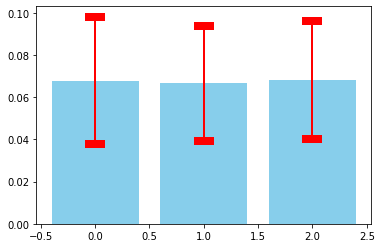

In [69]:
# plot the errors bar
values = average_error_sigma
errorValues = standard_deviation_sigma
plt.bar(range(len(values)), values, color = 'skyblue')
plt.errorbar(range(len(values)), values, yerr = errorValues,fmt = 'none', capsize = 10, ecolor = 'red', elinewidth = 2, capthick = 8)
plt.show()

## Comment : 

We can conlude that the more the variance increases, the more the mean error decreases. 
This can be justified by the fact that the more the variance increases, the more the points move away from each other and therefore by choosing a parameter of 1, the KNN becomes more precise.

## 2. k-Means algorithm for clustering

In [70]:
def plot_data_after_clustering(X, class_data, k_centroids):
    """This function plot ours dataset and centroids and different class"""
    centroid = list() 
    class_centroids = list()
    for i in k_centroids:
        centroid.append(k_centroids[i])
        class_centroids.append(i)
    centroid = np.array(centroid)

    plt.figure(figsize=(20,10))
    plt.scatter(X[:,0], X[:,1], c=class_data, label='Dataset')
    plt.scatter(centroid[:,0], centroid[:,1], s=1000, c=class_centroids, edgecolors='black', cmap='flag', alpha=0.5, label='Centroids')
    plt.title("The different classes obtained")
    plt.legend()
    plt.show()
    
#---------------------------------------------------------------------------------------------------------------#

def ploat_data_without_label(X):
    """This function plot our dataset"""
    
    plt.figure(figsize=(20,10))
    plt.scatter(X[:,0], X[:,1], label="Dataset")
    plt.title("Dataset without label")
    plt.legend()
    plt.show()
    
#---------------------------------------------------------------------------------------------------------------#

def objective_function_k_means(X_data, class_data, k_centroids):
    """This function compute the the global inertie"""
    
    objective_value = 0.0
    
    for i in range(X_data.shape[0]):        
        objective_value += np.sum((X_data[i] - k_centroids[class_data[i]])*(X_data[i] - k_centroids[class_data[i]]))
    
    return objective_value

#---------------------------------------------------------------------------------------------------------------#

def class_assignement(X_data, k_centroids):
    """This function dive compute the label"""
    class_data = list()
    
    for i in range(X_data.shape[0]):
        
        label = 0
        val = float_info.max
        
        for k in k_centroids:
            val_k = np.sum((X_data[i] - k_centroids[k])*(X_data[i] - k_centroids[k]))
            if val_k < val:
                val = val_k
                label = k
        
        class_data.append(label)

    return np.array(class_data)

#---------------------------------------------------------------------------------------------------------------#

def compute_centroids(X_data, class_data, number_class):
    """This function compute the barycenter of our different classes"""
    k_centroids = dict()
    number_element_per_classe = dict()
    
    for k in range(number_class):
        k_centroids[k] = X_data[0]*0.0
        number_element_per_classe[k] = 0
        
    for i in range(X_data.shape[0]):
        k_centroids[class_data[i]] = k_centroids[class_data[i]]+X_data[i]
        number_element_per_classe[class_data[i]] = number_element_per_classe[class_data[i]] + 1
        
    for k in k_centroids:
        k_centroids[k] = k_centroids[k] / number_element_per_classe[k]
        
        
    return k_centroids

#---------------------------------------------------------------------------------------------------------------#

In [71]:
def k_means_clustering(X_data, number_cluster):
    """This function take a set of data and buld number cluster using k_means"""
    
    objective_function_value_0 = 0.0
    convergence = 1000.0
    
    #max iteration 10000
    max_iteration = 10
    
    
    # initialization of centroids
    k_centroids = dict()
    for k in range(number_cluster):
        k_centroids[k] = X_data[np.random.randint(X_data.shape[0])]
    
    # generate the classe of data
    class_data = np.zeros(X_data.shape[0])
    
    iteration = 0 
    #while( iteration < max_iteration and convergence > 0.02):
    for i in range(max_iteration):
        # compute the class
        class_data = class_assignement(X_data, k_centroids)
        
        # compute the k_centroids
        k_centroids = compute_centroids(X_data, class_data, number_cluster)
        # compute the objective function
        convergence = objective_function_value_0
        objective_function_value_0 = objective_function_k_means(X_data, class_data, k_centroids)
    
        # This means we have a convergence
        if(np.abs(convergence-objective_function_value_0) < 0.002):
            break
            
    return class_data, k_centroids, iteration

### Question 1

In [72]:
#size per label 
N = 100

# Gaussian mean for distribution label 0
mu_label_0 = np.array([-1,0])

# Gaussian mean for distribution label 1
mu_label_1 = np.array([1,0])

# Gaussian mean for distribution label 2
mu_label_2 = np.array([0,1])


# standar deviation for Gaussian Distribution
sigma_ = 0.15
matrix_cov =sigma_* np.array([[1, 0],[0, 1]])

In [73]:
# Generation of the data
X,Y = generate_data(N, mu_label_0, mu_label_1, mu_label_2, matrix_cov)

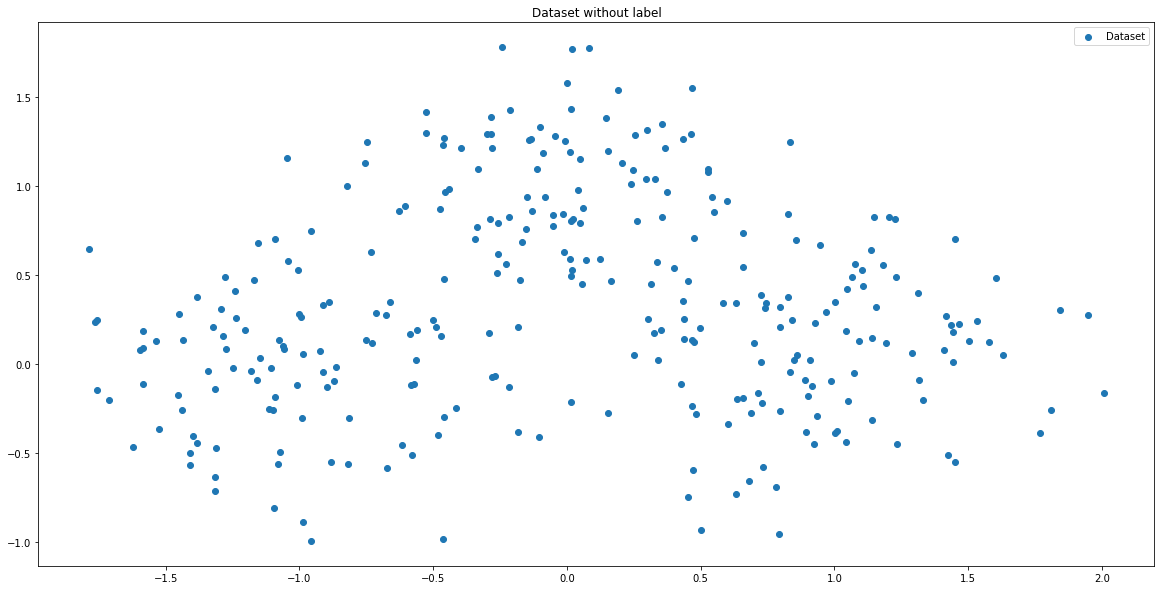

In [74]:
ploat_data_without_label(X)

#### For K = 3

In [75]:
#build clusters
class_data, k_centroids, iteration = k_means_clustering(X, 3)

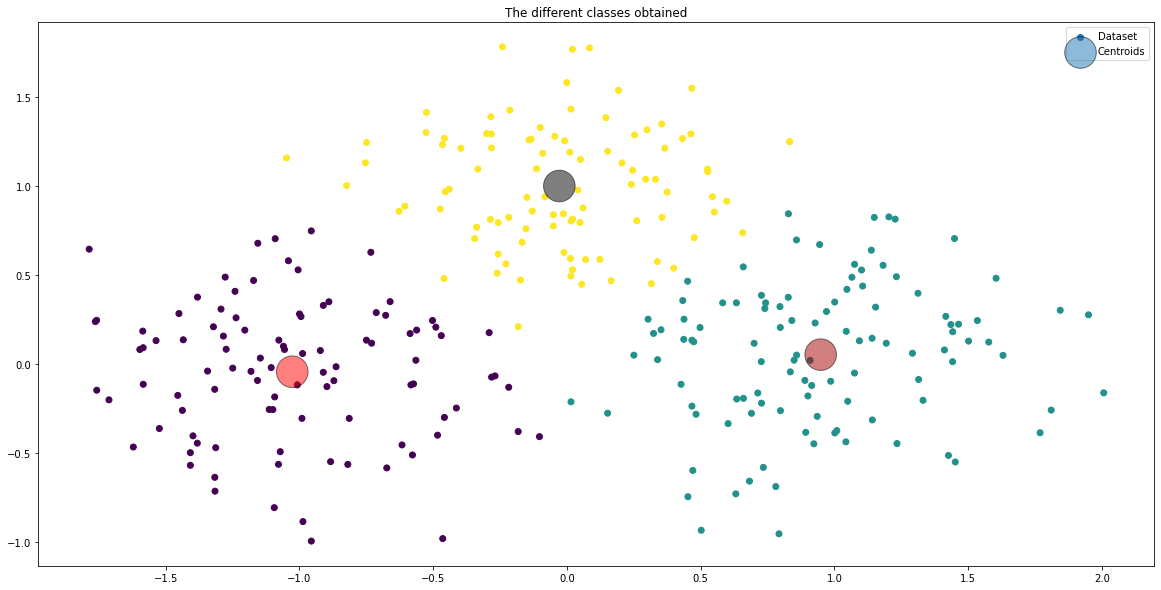

In [76]:
plot_data_after_clustering(X, class_data, k_centroids)

#### For K = 2

In [77]:
#build cluster
class_data, k_centroids, iteration = k_means_clustering(X, 2)

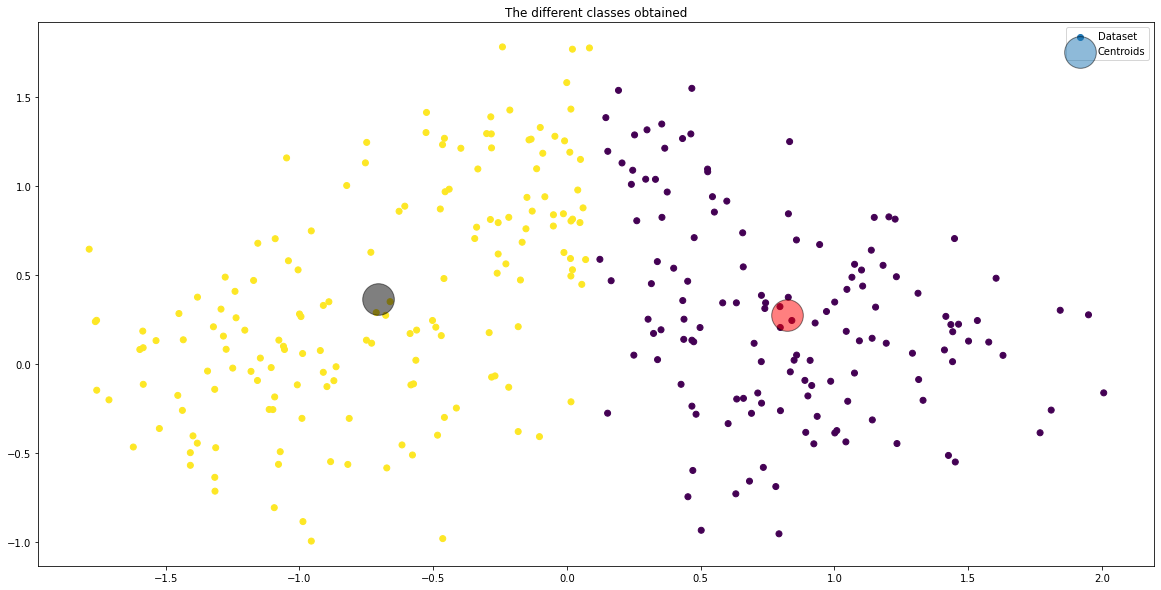

In [78]:
plot_data_after_clustering(X, class_data, k_centroids)

#### For K = 4

In [79]:
#build cluster
class_data, k_centroids, iteration = k_means_clustering(X, 4)

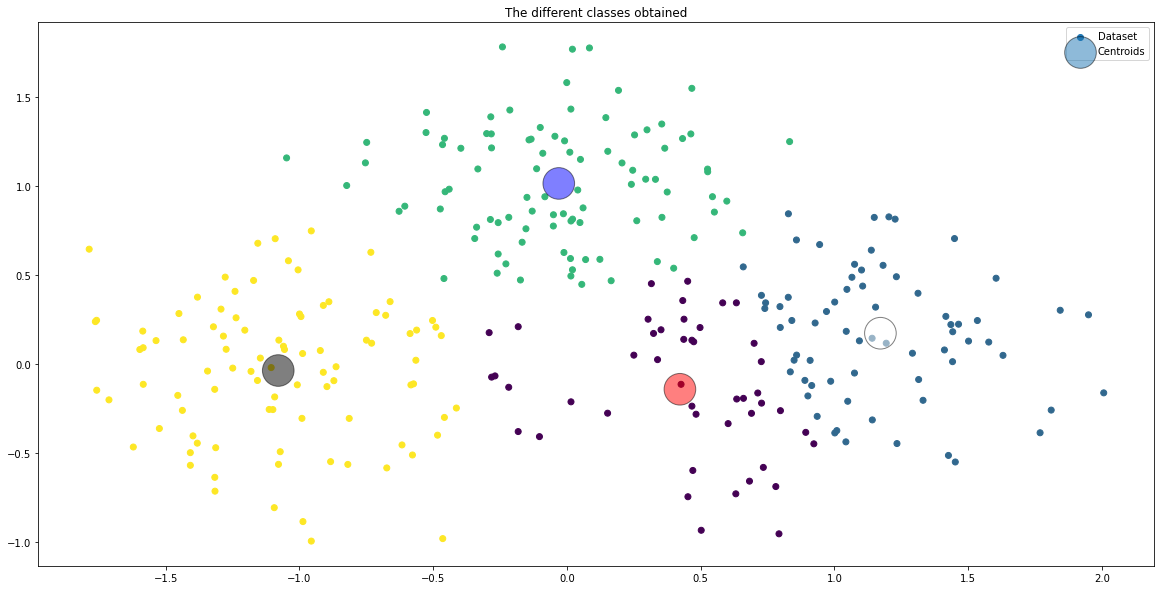

In [80]:
plot_data_after_clustering(X, class_data, k_centroids)

#### For K = 6

In [81]:
#build cluster
class_data, k_centroids, iteration = k_means_clustering(X, 6)

c:\python36\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


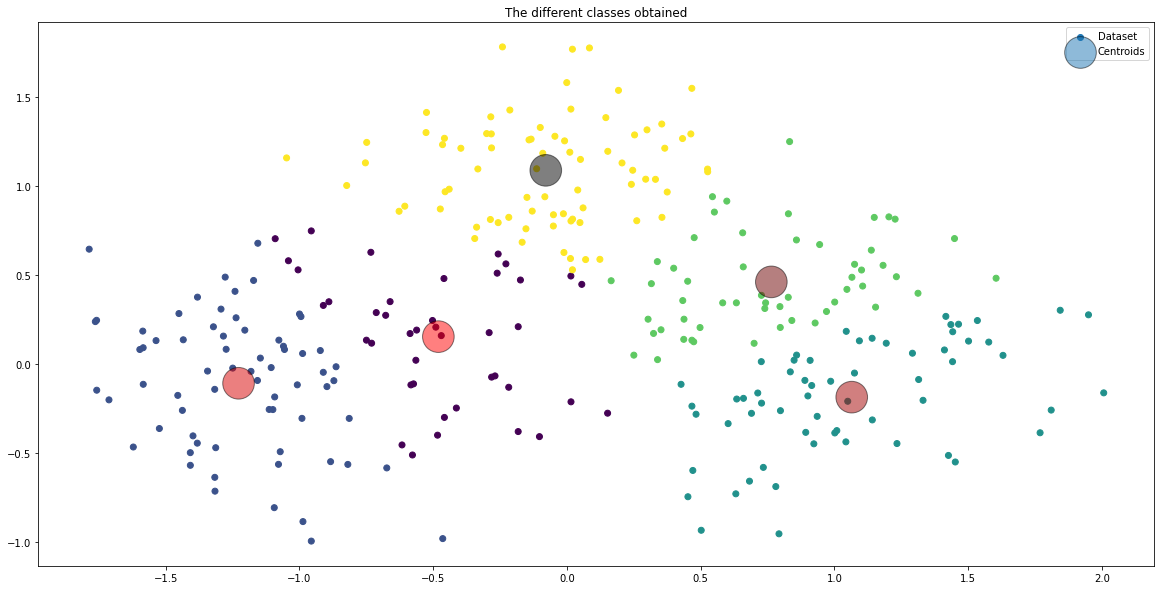

In [82]:
plot_data_after_clustering(X, class_data, k_centroids)

### Comment : 

We can see that the centroids obtained at the convergence are at the center of the classes. This is normal in our opinion because the latter are in fact the barycenters of the classes considered.

### Question 2

In [83]:
def plot_centroid_(centroids_input, centroids_convergence):
    """We use this function for to plot the centroids"""

    centroid_input_dataset = list() 
    centroid_convergence = list() 
    class_centroids = list()

    for i in k_centroids:
        centroid_convergence.append(centroids_convergence[i])
        centroid_input_dataset.append(centroids_input[i])
        class_centroids.append(i)
    
    centroid_convergence = np.array(centroid_convergence)
    centroid_input_dataset = np.array(centroid_input_dataset)

    plt.figure(figsize=(20,10))
    plt.scatter(centroid_convergence[:,0], centroid_convergence[:,1], s=1000, c="black", edgecolors='black', cmap='flag', alpha=0.5, label='Centroids Convergence')
    plt.scatter(centroid_input_dataset[:,0], centroid_input_dataset[:,1], s=1000, c="red", edgecolors='black', cmap='autumn', alpha=1, label='Centroid Input Dataset')


    plt.title("The different classes obtained")
    plt.legend()
    plt.show()

In [84]:
#size per label 
N = 100

# Gaussian mean for distribution label 0
mu_label_0 = np.array([-1,0])

# Gaussian mean for distribution label 1
mu_label_1 = np.array([1,0])

# Gaussian mean for distribution label 2
mu_label_2 = np.array([0,1])

#### For sigma = 0.10

In [85]:
sigma_ = 0.10
matrix_cov =sigma_* np.array([[1, 0],[0, 1]])

# Generation of the data
X,Y = generate_data(N, mu_label_0, mu_label_1, mu_label_2, matrix_cov)

In [86]:
# We compute the input centroides
centroids_input = compute_centroids(X, Y, 3)

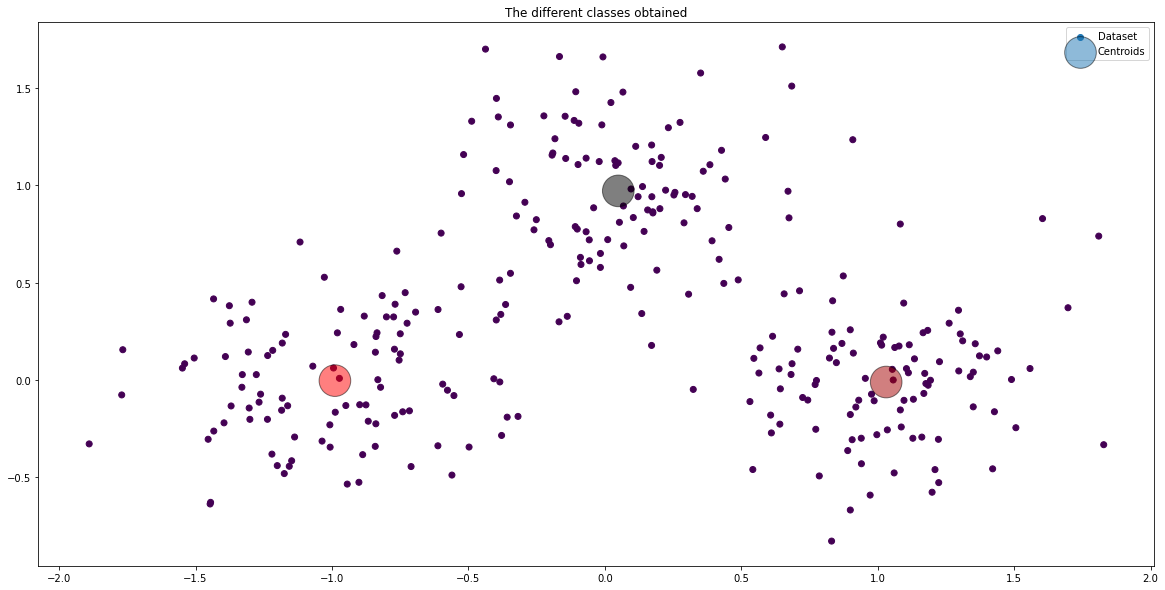

In [87]:
plot_data_after_clustering(X, Y*0, centroids_input)

In [88]:
#build cluster
class_data, k_centroids, iteration = k_means_clustering(X, 3)

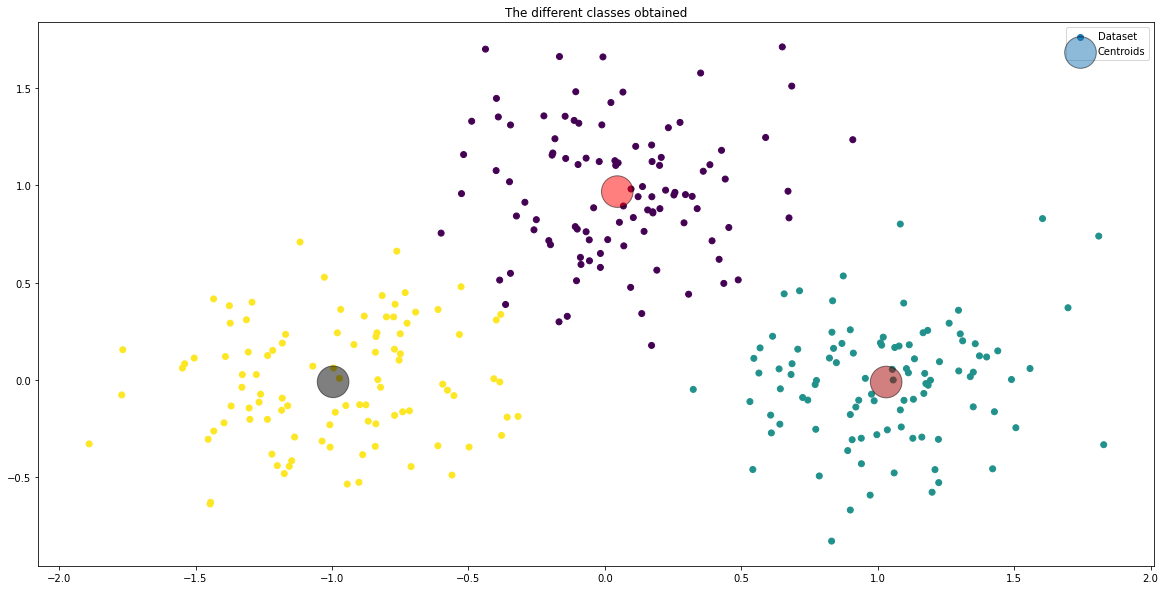

In [89]:
plot_data_after_clustering(X, class_data, k_centroids)

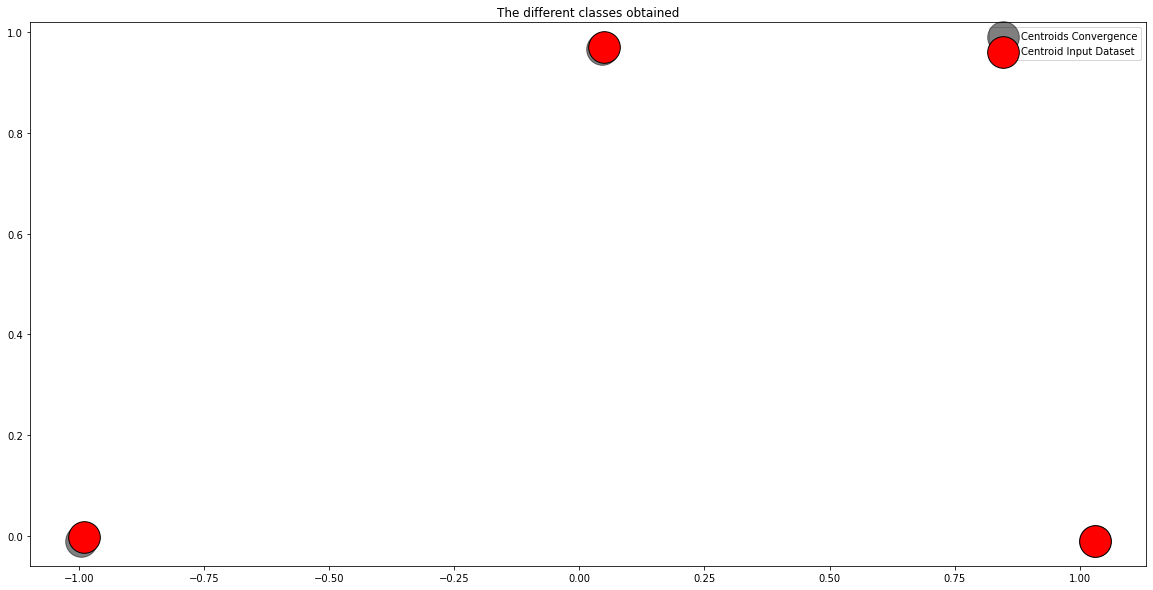

In [90]:
plot_centroid_(centroids_input, k_centroids)

#### For sigma = 0.25

In [91]:
sigma_ = 0.25
matrix_cov =sigma_* np.array([[1, 0],[0, 1]])

# Generation of the data
X,Y = generate_data(N, mu_label_0, mu_label_1, mu_label_2, matrix_cov)

In [92]:
# We compute the input centroides
centroids_input = compute_centroids(X, Y, 3)

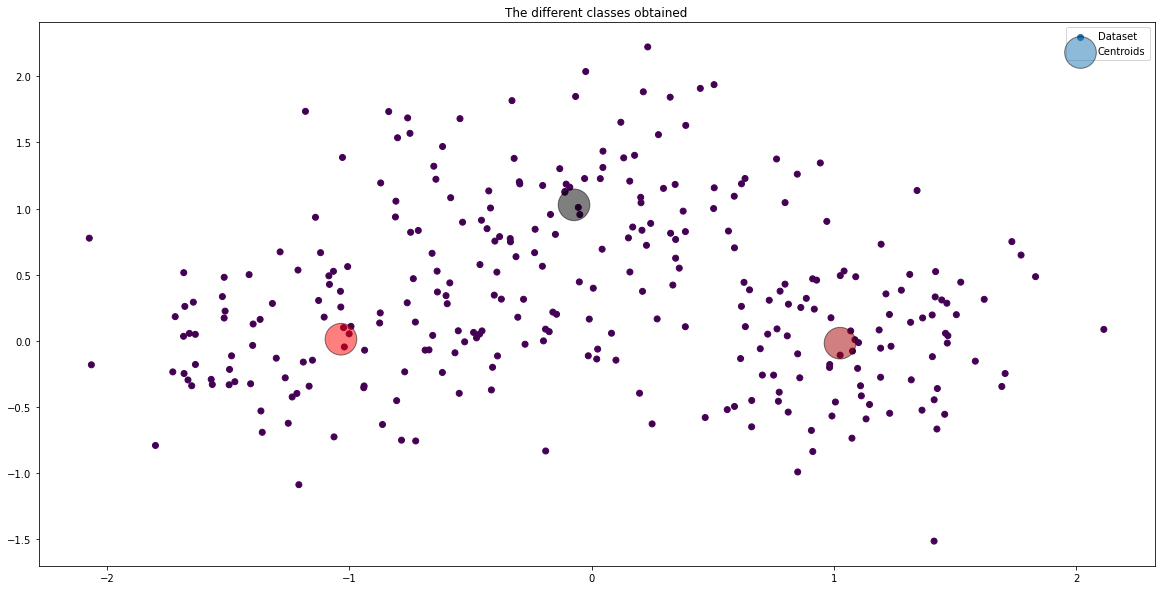

In [93]:
plot_data_after_clustering(X, Y*0, centroids_input)

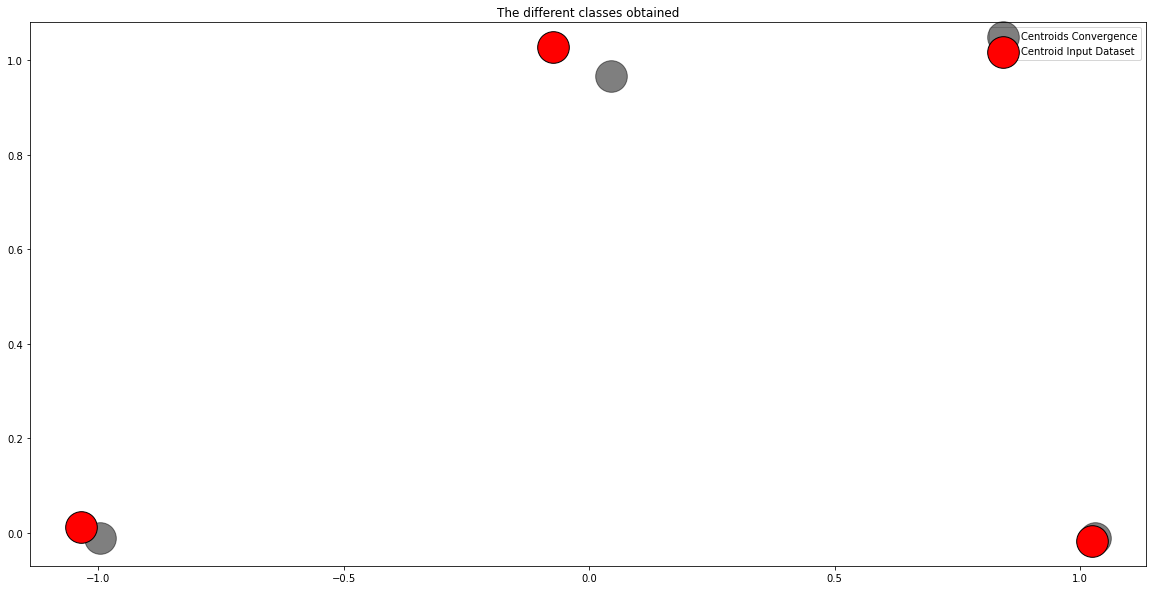

In [94]:
plot_centroid_(centroids_input, k_centroids)

#### For sigma = 0.50

In [95]:
sigma_ = 0.50
matrix_cov =sigma_* np.array([[1, 0],[0, 1]])

# Generation of the data
X,Y = generate_data(N, mu_label_0, mu_label_1, mu_label_2, matrix_cov)

In [96]:
# We compute the input centroides
centroids_input = compute_centroids(X, Y, 3)

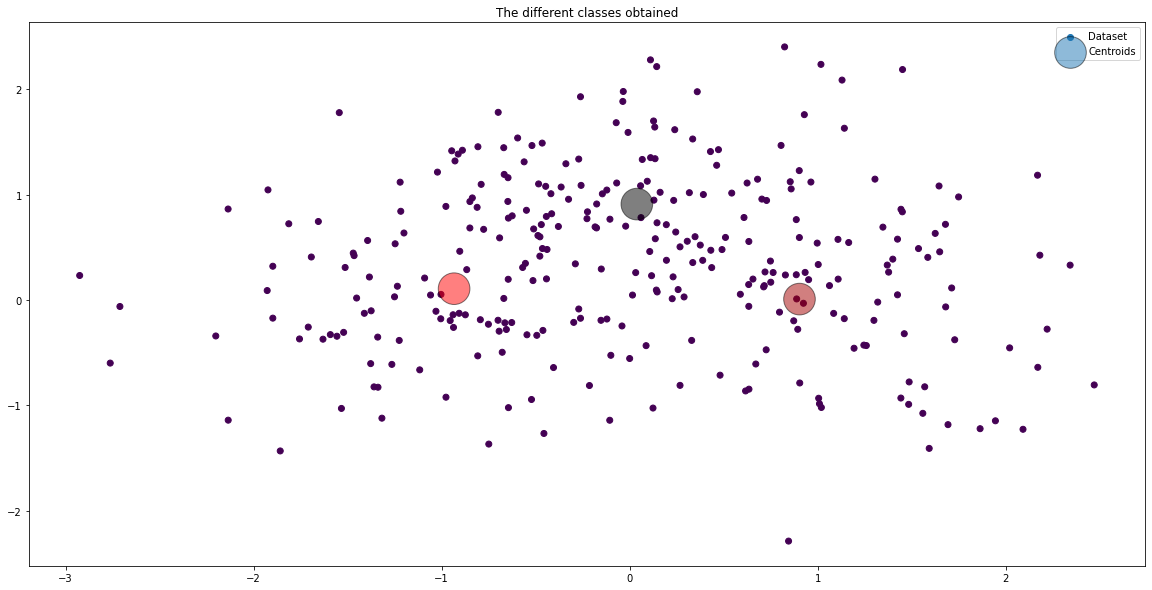

In [97]:
plot_data_after_clustering(X, Y*0, centroids_input)

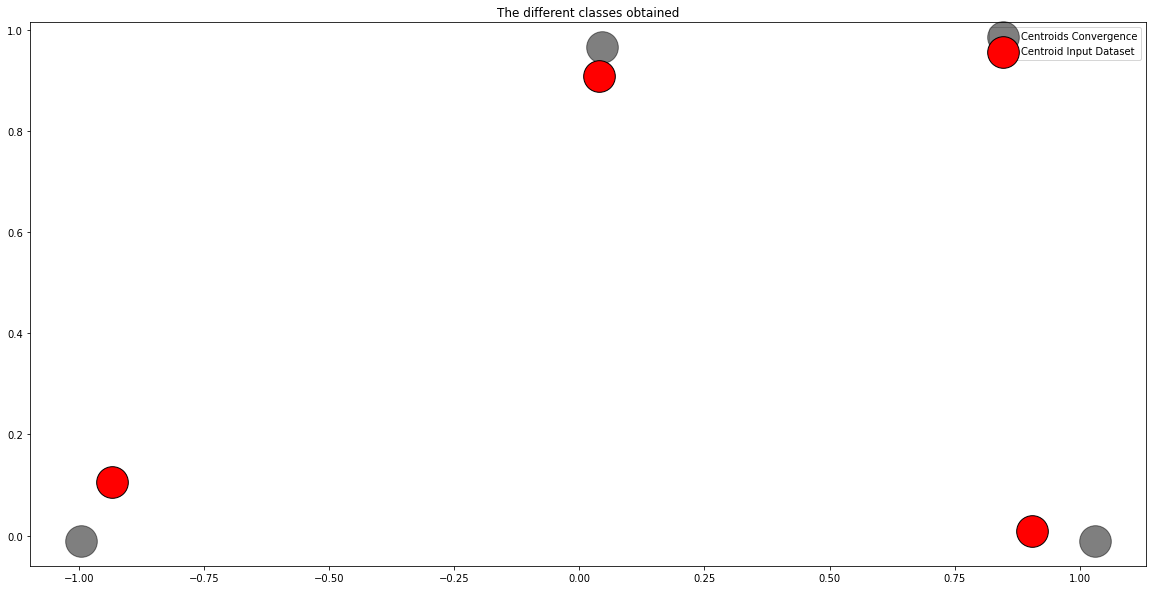

In [98]:
plot_centroid_(centroids_input, k_centroids)

### Comment : 

We can see that the centroids of the input data and the centroids obtained at the convergence are almost equal. As the variance increase, they become more distant but not a lot.

# II. k-NN regression: Szeged-weather data-set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from numpy import linalg as LA
from sklearn.model_selection import KFold

In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rcparam was deprecated in Matplo

## Data Preparation

In [2]:
weather_data_raw = pd.read_csv("data/weatherHistory.csv")
weather_data = weather_data_raw.iloc[0:2000]

weather_data = weather_data.sample(frac=1).reset_index(drop=True)
weather_data.head(3)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-12-15 01:00:00.000 +0100,Foggy,snow,-1.566667,-1.566667,1.00,2.4472,43.0,0.161,0.0,1034.34,Foggy throughout the day.
1,2006-04-24 02:00:00.000 +0200,Clear,rain,12.383333,12.383333,0.80,4.6207,172.0,14.168,0.0,1019.59,Partly cloudy until evening.
2,2006-12-12 12:00:00.000 +0100,Foggy,rain,2.044444,-1.961111,0.93,15.4882,189.0,0.966,0.0,1029.30,Foggy throughout the day.


## Question 1 :

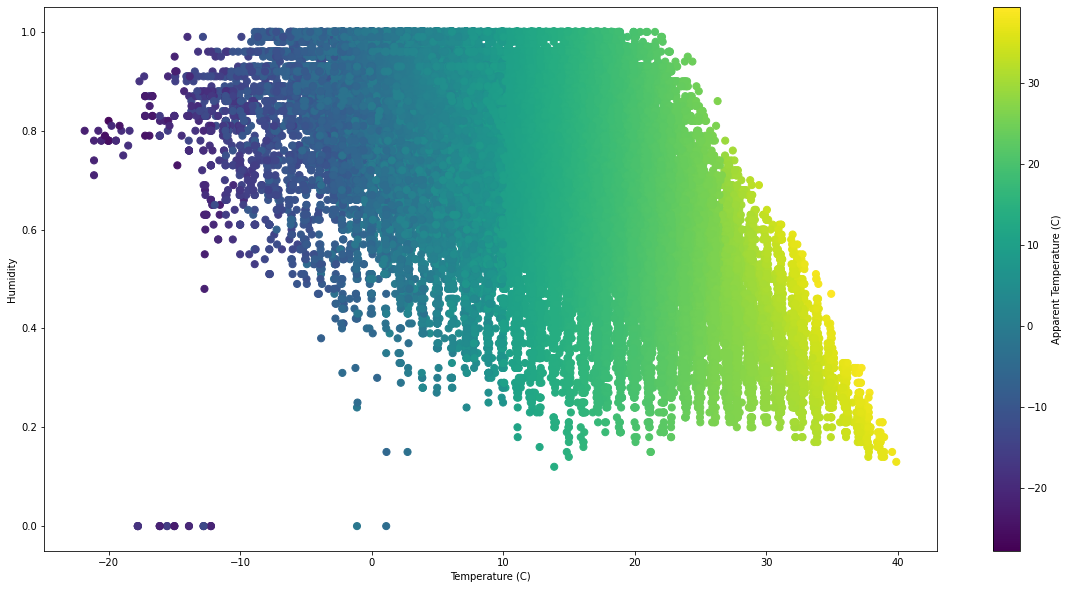

In [3]:
plt.figure(figsize=(20,10))
plt.scatter(weather_data_raw["Temperature (C)"], weather_data_raw["Humidity"], s=50, c=weather_data_raw["Apparent Temperature (C)"])
plt.xlabel("Temperature (C)")
plt.ylabel("Humidity")

cb = plt.colorbar()
cb.set_label("Apparent Temperature (C)")

plt.show()


## Question 2 :

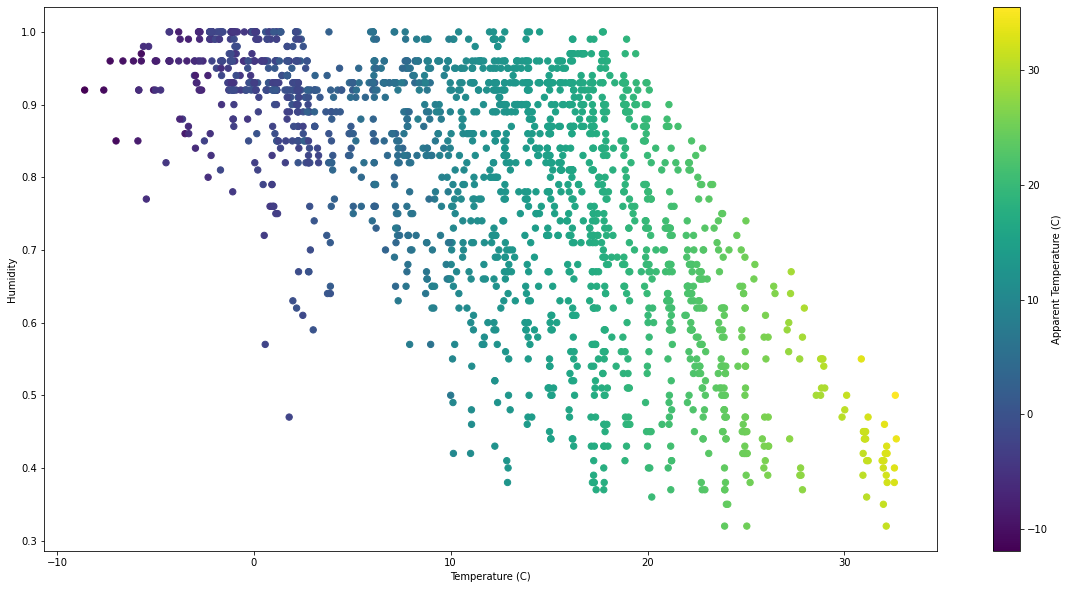

In [4]:
plt.figure(figsize=(20,10))
plt.scatter(weather_data["Temperature (C)"], weather_data["Humidity"], s=40, c=weather_data["Apparent Temperature (C)"])
plt.xlabel("Temperature (C)")
plt.ylabel("Humidity")

cb = plt.colorbar()
cb.set_label("Apparent Temperature (C)")

plt.show()

In [5]:
kfold = KFold(n_splits=2, shuffle=True, random_state=10)

train_dataset = list()
test_dataset = list()
for train_index, test_index in kfold.split(weather_data):
    train_dataset.append(weather_data.iloc[train_index])
    test_dataset.append(weather_data.iloc[test_index])
    


In [6]:
def PreProcessData(pd_data, split_N=5):
    data = pd_data.filter(items=["Temperature (C)", "Humidity", "Apparent Temperature (C)"])
    data['est_Temp'] = 0.0
    kfold = KFold(n_splits=split_N, shuffle=True, random_state=10)

    train_dataset = list()
    test_dataset = list()
    for train_index, test_index in kfold.split(data):
        train_dataset.append(data.iloc[train_index])
        test_dataset.append(data.iloc[test_index])
    
    return train_dataset, test_dataset

def FindNearstKPoints(data, target, k):
    dx_square = np.power(data['Temperature (C)'].to_numpy() - target[0], 2)
    dy_square = np.power(data['Humidity'].to_numpy() - target[1], 2)
    dist_list = np.sqrt(dx_square + dy_square)
    
    near_indexs = sorted(range(len(dist_list)), key=lambda k: dist_list[k])
    return data["Apparent Temperature (C)"].to_numpy()[near_indexs[1:k+1]]

def WeightLabel(labels):
    count_list = np.zeros((3, 1))
    for l in labels:
        count_list[l] = count_list[l] + 1
    return np.argmax(count_list) 

def EvaluateEstimation(data, est_data):
    app_temp = data["Apparent Temperature (C)"].to_numpy().reshape((data.shape[0], 1))
    est_app_temp = data['est_Temp'].to_numpy().reshape((data.shape[0], 1))
    error = est_app_temp - app_temp 
    
    mse = (error**2).mean()
    std = np.std(error)
    return error, mse, std
    
    
def KNNAlg(train_data, test_data, k):
    err_count = 0
    error_point = list()
    for index, row in test_data.iterrows():
        est_temps = FindNearstKPoints(train_data, (row['Temperature (C)'], row['Humidity']), k)
        test_data.at[index, 'est_Temp'] = np.mean(est_temps)
    
    return test_data.copy()

In [105]:
split_N = 5
K = 1
train_dataset, test_dataset = PreProcessData(weather_data, split_N=split_N)

total_mse = 0.0
total_std = 0.0

print("K:", K)
mse_list = []
for i in range(split_N): 
    est_test_data = KNNAlg(train_dataset[i], test_dataset[i], K)
    error, mse, _ = EvaluateEstimation(test_dataset[i], est_test_data)
    mse_list.append(mse)

mean_mse = np.mean(mse_list)
std_mse = np.std(mse_list)
print(mean_mse, std_mse, "\n")

K: 1
1.2183374845679011 0.1270599659798763 



## Question 3 :

In [106]:
split_N = 5
K_list = [3,5,7,10,15];
train_dataset, test_dataset = PreProcessData(weather_data, split_N=split_N)

K_mse_list = list()
K_std_list = list()
for K in K_list:
    print("K:", K)
    for i in range(split_N): 
        est_test_data = KNNAlg(train_dataset[i], test_dataset[i], K)
        error, mse, _ = EvaluateEstimation(test_dataset[i], est_test_data)
        mse_list.append(mse)

    mean_mse = np.mean(mse_list)
    std_mse = np.std(mse_list)
    print(mean_mse, std_mse, "\n")
    K_mse_list.append(mean_mse)
    K_std_list.append(std_mse)

K: 3
1.06587620627572 0.18465606987822397 

K: 5
1.0047986167352538 0.1877370160728647 

K: 7
0.965793654775552 0.19077364294332166 

K: 10
0.9445774694994542 0.1861544696335564 

K: 15
0.9319539380373825 0.18202658384322484 



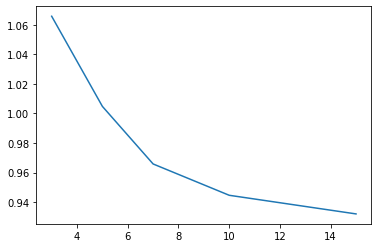

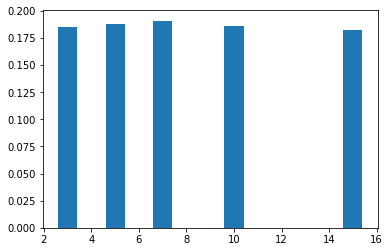

In [107]:
plt.plot(K_list, K_mse_list)
plt.show()

plt.bar(K_list, K_std_list)
plt.show()

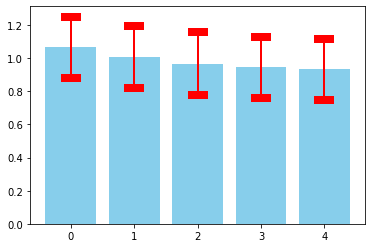

In [108]:
# plot the errors bar
values = K_mse_list
errorValues = K_std_list
plt.bar(range(len(values)), values, color = 'skyblue')
plt.errorbar(range(len(values)), values, yerr = errorValues,fmt = 'none', capsize = 10, ecolor = 'red', elinewidth = 2, capthick = 8)
plt.show()

## Comments :

We remark that the higher the number of neighboors, the better the MSE. However, at a certain number of neighboors, the MSE is the same. 
There's also a number for which the MSE gets higher.

Let's find them ! :D

In [109]:
split_N = 5
K_list = [3,5,7,10,15, 20, 30,40 , 60, 80];
train_dataset, test_dataset = PreProcessData(weather_data, split_N=split_N)

K_mse_list = list()
K_std_list = list()
for K in K_list:
    print("K:", K)
    for i in range(split_N): 
        est_test_data = KNNAlg(train_dataset[i], test_dataset[i], K)
        error, mse, _ = EvaluateEstimation(test_dataset[i], est_test_data)
        mse_list.append(mse)

    mean_mse = np.mean(mse_list)
    std_mse = np.std(mse_list)
    print(mean_mse, std_mse, "\n")
    K_mse_list.append(mean_mse)
    K_std_list.append(std_mse)

K: 3
0.9293055080296906 0.17098841629562783 

K: 5
0.9234727492327692 0.16647877170337053 

K: 7
0.9151734180842892 0.16608794762269743 

K: 10
0.9096273491153662 0.16423206979828825 

K: 15
0.9059190701709715 0.16292452191020942 

K: 20
0.9039962176316468 0.1607968779807621 

K: 30
0.9040960130122029 0.15838170494608284 

K: 40
0.9072552701673883 0.15759935776050318 

K: 60
0.922128280431549 0.1719526795783109 

K: 80
0.9485832168882894 0.20938582047011625 



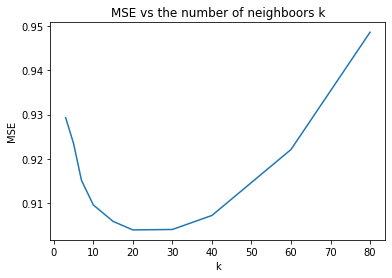

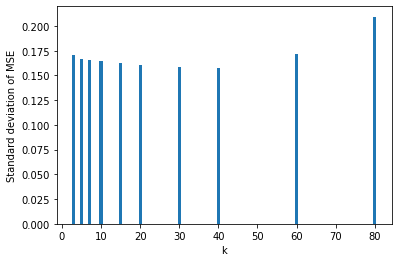

In [110]:
plt.plot(K_list, K_mse_list)
plt.xlabel("k")
plt.ylabel("MSE")
plt.title("MSE vs the number of neighboors k")
plt.show()

plt.bar(K_list, K_std_list)
plt.xlabel("k")
plt.ylabel("Standard deviation of MSE")
plt.show()

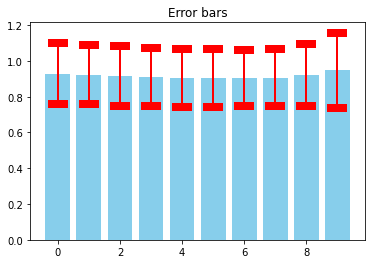

In [111]:
# plot the errors bar
values = K_mse_list
errorValues = K_std_list
plt.bar(range(len(values)), values, color = 'skyblue')
plt.errorbar(range(len(values)), values, yerr = errorValues,fmt = 'none', capsize = 10, ecolor = 'red', elinewidth = 2, capthick = 8)
plt.title("Error bars")
plt.show()

## Comments :

We can conclude that the best values for number of neighboors (k) are in the intervale [20,30].

We have prooved that thinking that for higher values of k we have better MSE is not true. In fact, in this case, for k > 30 we will be having worse MSE. This is predictible, we can see from the distributions of the points in our datasets, that the data points are close to each others which means that the more we increase k the more we will have missdetection.